<a href="https://colab.research.google.com/github/NateLeMonnier/avalanche-web-scraper-and-analyzer/blob/main/AvalancheWebScraperAndAnalyzer_NathanLeMonnier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nathan LeMonnier <br>
Data Wrangling <br>
Professor Kogan <br>
Avalanche Web Scraper and Analyzer <br>
20-Oct-2024

# DS 2500 Exploratory Data Analysis

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

import requests

# BeautifulSoup is a module inside the "bs4" library, we only import the BeautifulSoup module
from bs4 import BeautifulSoup

import pandas as pd
from scipy.stats import f_oneway, chi2_contingency

# 1. Formulate your questions



In the last ten years, when in the year do the most avalanches take place in Utah? What regions are most susceptible? Additionally, do region and avalanche trigger relate?

### What data could answer this question?
The data that I will use to answer this question is the Utah Avalanche Center's Avalanche page which contains all reported Avalanches for the last multiple decades.
The data "lives" at the Utah Avalanche Center.org website. It's relevancy is obvious and its potential biases are small. However, one bias is underreported avalanches in regions that do not have a large population. This will slightly affect answering my questions, but should not hinder obtaining an accurate answer.

# 2. Read in your data

## Web Scraping


First, I use Requests to get the HTML text of my chosen website, the Utah Avalanche Center. From here, I use the Beautiful Soup library to begin the process of reading in my data.

In [ ]:
HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}

avalanche_raw = requests.get('https://utahavalanchecenter.org/avalanches', headers=HEADERS).text

avalanche_soup = BeautifulSoup(avalanche_raw,'html.parser')

### Tags
While I originally planned to include the HTML text of the website here, I found that the huge amount of text made scrolling through the page difficult. Instead, I chose to simply dive through the HTML on the website with the Inspect tool.

### What I found
I found that the table containing my data was in a \<table> section deep in the HTML body. From here, I found the specific tags for all of the table variables: Date, Title, Region, Trigger, Depth, and Width.

Using these tags and Beautiful Soup's find_all method, I narrowed down the HTML into multiple lists with elements of the HTML text containing the variable information.

In [ ]:
avalanche_title = avalanche_soup.find_all('td',{'class':'views-field views-field-title'})
print(avalanche_title)

[<td class="views-field views-field-title">
<a href="/avalanche/88097">Avalanche: Provo</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/88099">Avalanche: Timpanogos</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/88095">Avalanche: Provo</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/88096">Avalanche: Provo</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87661">Avalanche: Salt Lake</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87662">Avalanche: Bald Mountain</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87644">Avalanche: Wolverine Cirque</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87651">Avalanche: Mill B South</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87629">Avalanche: Spring Creek</a> </td>, <td class="views-field views-field-title">
<a href="/avalanche/87600">Avala

In [ ]:
avalanche_title[0].text.strip()

'Avalanche: Provo'

In [ ]:
avalanche_region = avalanche_soup.find_all('td',{'class':'views-field views-field-field-region-forecaster nowrap'})
avalanche_date = avalanche_soup.find_all('td',{'class':'views-field views-field-field-occurrence-date'})
avalanche_trigger = avalanche_soup.find_all('td',{'class':'views-field views-field-field-trigger'})
avalanche_depth = avalanche_soup.find_all('td',{'class':'views-field views-field-field-depth views-align-right'})
avalanche_width = avalanche_soup.find_all('td',{'class':'views-field views-field-field-width views-align-right'})
print('date',avalanche_date)
print('region',avalanche_region)
print('trigger',avalanche_trigger)
print('depth',avalanche_depth)
print('width',avalanche_width)

date [<td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">10/19/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">10/19/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">10/18/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">10/18/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">6/2/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">5/30/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">5/26/2024</span> </td>, <td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">5/26/2024</span> </td>, <td class="views-field views-field-field-occurrence-dat

From here, it is simple to check each of my variable lists. I wanted to make sure that using .text.strip() worked for each of the HTML lines.

In [ ]:
print(avalanche_date[0].text.strip())
print(avalanche_title[0].text.strip())
print(avalanche_region[0].text.strip())
print(avalanche_trigger[0].text.strip())
print(avalanche_depth[0].text.strip())
print(avalanche_width[0].text.strip())

10/19/2024
Avalanche: Provo
Provo
Natural
10"
100'


Here is where I found somewhat of a **bug**. I found that the avalanche dates are formatted strangely and reacted by reformatting them.

In [ ]:
avalanche_date_reformat = []
for date in avalanche_date:
  avalanche_date_reformat.append(date.find('span',{'class':'date-display-single'}).text.strip())
print(avalanche_date_reformat[0])

10/19/2024


With my data all correctly formatted, I created new sets to contain the information in order to transform the data into a DataFrame. Most of the following ideas were provided to us in class!

In [ ]:
dates = []
titles = []
regions = []
triggers = []
depths = []
widths = []
for date in avalanche_date_reformat:
  dates.append(date)
for title in avalanche_title:
  titles.append(title.text.strip())
for region in avalanche_region:
  regions.append(region.text.strip())
for trigger in avalanche_trigger:
  triggers.append(trigger.text.strip())
for depth in avalanche_depth:
  depths.append(depth.text.strip())
for width in avalanche_width:
  widths.append(width.text.strip())

In [ ]:
avalanche_page0 = []
for i in range(len(dates)):

  # Each entry (row) contains a Date, Title, Region, Trigger, Depth, and Width.
  avalanche_entry = {
      'Date':dates[i],
      'Title':titles[i],
      'Region':regions[i],
      'Trigger':triggers[i],
      'Depth':depths[i],
      'Width':widths[i]
  }
  avalanche_page0.append(avalanche_entry)

avalanche_page0_df = pd.DataFrame(avalanche_page0)
avalanche_page0_df.head()

,Date,Title,Region,Trigger,Depth,Width
0,10/19/2024,Avalanche: Provo,Provo,Natural,"10""",100'
1,10/19/2024,Avalanche: Timpanogos,Provo,Natural,,
2,10/18/2024,Avalanche: Provo,Provo,Natural,"10""",90'
3,10/18/2024,Avalanche: Provo,Provo,Natural,"16""",70'
4,6/2/2024,Avalanche: Salt Lake,Salt Lake,Skier,"5""",15'


Success!

Now that we succesfully transformed the information on the first page into a DataFrame, I can use the same method for the other 129 pages.

In [ ]:
def parse_avalanches(groups):
  # Each page will have dates, titles, regions, triggers, depths, and widths.
  dates = []
  titles = []
  regions = []
  triggers = []
  depths = []
  widths = []

  # This list will contain the data from each entry.
  avalanche_page = []

  # Narrowing the HTML text down to a list containing the correct lines of text.
  for group in groups:
    avalanche_title = groups.find_all('td',{'class':'views-field views-field-title'})
    avalanche_region = groups.find_all('td',{'class':'views-field views-field-field-region-forecaster nowrap'})
    avalanche_date = groups.find_all('td',{'class':'views-field views-field-field-occurrence-date'})
    avalanche_trigger = groups.find_all('td',{'class':'views-field views-field-field-trigger'})
    avalanche_depth = groups.find_all('td',{'class':'views-field views-field-field-depth views-align-right'})
    avalanche_width = groups.find_all('td',{'class':'views-field views-field-field-width views-align-right'})

  # Adding solely the text to their respective lists.
  avalanche_date_reformat = []
  for date in avalanche_date:
    avalanche_date_reformat.append(date.find('span',{'class':'date-display-single'}).text.strip())
  for date in avalanche_date_reformat:
    dates.append(date)
  for title in avalanche_title:
    titles.append(title.text.strip())
  for region in avalanche_region:
    regions.append(region.text.strip())
  for trigger in avalanche_trigger:
    triggers.append(trigger.text.strip())
  for depth in avalanche_depth:
    depths.append(depth.text.strip())
  for width in avalanche_width:
    widths.append(width.text.strip())

  for i in range(len(dates)):
    avalanche_entry = {
        'Date':dates[i],
        'Title':titles[i],
        'Region':regions[i],
        'Trigger':triggers[i],
        'Depth':depths[i],
        'Width':widths[i]
    }

    avalanche_page.append(avalanche_entry)

  # Returning the list of dictionaries.
  return avalanche_page

Now, we can use our parser function for every page within the range of 2024 to 2000.

In [ ]:
from time import sleep

As we learned in class, I will wait one second between each page request.

In [ ]:
avalanche_pages = dict()
for page in range(0,129):
  sleep(1)

  # Get the raw HTML. Code provided in class.
  HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
  avalanche_raw = requests.get('https://utahavalanchecenter.org/avalanches?page={0}'.format(page),headers=HEADERS).text

  avalanche_soup = BeautifulSoup(avalanche_raw,'html.parser')

  avalanche_data = parse_avalanches(avalanche_soup)

  avalanche_pages[page] = pd.DataFrame(avalanche_data)

  print('Page {0} parsed'.format(page))

avalanche_allpages = pd.concat(avalanche_pages)
avalanche_allpages.head()

Page 0 parsed
Page 1 parsed
Page 2 parsed
Page 3 parsed
Page 4 parsed
Page 5 parsed
Page 6 parsed
Page 7 parsed
Page 8 parsed
Page 9 parsed
Page 10 parsed
Page 11 parsed
Page 12 parsed
Page 13 parsed
Page 14 parsed
Page 15 parsed
Page 16 parsed
Page 17 parsed
Page 18 parsed
Page 19 parsed
Page 20 parsed
Page 21 parsed
Page 22 parsed
Page 23 parsed
Page 24 parsed
Page 25 parsed
Page 26 parsed
Page 27 parsed
Page 28 parsed
Page 29 parsed
Page 30 parsed
Page 31 parsed
Page 32 parsed
Page 33 parsed
Page 34 parsed
Page 35 parsed
Page 36 parsed
Page 37 parsed
Page 38 parsed
Page 39 parsed
Page 40 parsed
Page 41 parsed
Page 42 parsed
Page 43 parsed
Page 44 parsed
Page 45 parsed
Page 46 parsed
Page 47 parsed
Page 48 parsed
Page 49 parsed
Page 50 parsed
Page 51 parsed
Page 52 parsed
Page 53 parsed
Page 54 parsed
Page 55 parsed
Page 56 parsed
Page 57 parsed
Page 58 parsed
Page 59 parsed
Page 60 parsed
Page 61 parsed
Page 62 parsed
Page 63 parsed
Page 64 parsed
Page 65 parsed
Page 66 parsed
Page 

Date                  Title     Region  Trigger Depth Width
0 0  10/19/2024       Avalanche: Provo      Provo  Natural   10"  100'
  1  10/19/2024  Avalanche: Timpanogos      Provo  Natural            
  2  10/18/2024       Avalanche: Provo      Provo  Natural   10"   90'
  3  10/18/2024       Avalanche: Provo      Provo  Natural   16"   70'
  4    6/2/2024   Avalanche: Salt Lake  Salt Lake    Skier    5"   15'

Success! Seeing my new DataFrame with all the information from each page was extremely rewarding.

In [ ]:
avalanche_allpages.head()

Date                  Title     Region  Trigger Depth Width
0 0  10/19/2024       Avalanche: Provo      Provo  Natural   10"  100'
  1  10/19/2024  Avalanche: Timpanogos      Provo  Natural            
  2  10/18/2024       Avalanche: Provo      Provo  Natural   10"   90'
  3  10/18/2024       Avalanche: Provo      Provo  Natural   16"   70'
  4    6/2/2024   Avalanche: Salt Lake  Salt Lake    Skier    5"   15'

In [ ]:
avalanche_allpages.tail()

Date                     Title     Region      Trigger Depth  \
128 45    1/9/2014  Avalanche: Reynolds Peak  Salt Lake      Natural   10"   
    46    1/9/2014  Avalanche: Reynolds Peak  Salt Lake      Natural   12"   
    47    1/6/2014    Avalanche: Pointy Peak  Salt Lake      Natural         
    48    1/5/2014       Avalanche: Monitors  Salt Lake      Natural   15"   
    49  12/27/2013  Avalanche: Whitney Basin     Uintas  Snowmobiler  2.5'   

       Width  
128 45  100'  
    46   40'  
    47   80'  
    48   15'  
    49   50'

## Data Cleaning

The last entry of the DataFrame is from 2013 and I will need to drop it.

In [ ]:
avalanche_allpages.reset_index(drop=True, inplace=True)
avalanche_allpages.drop(index=6449,inplace=True)
avalanche_allpages.tail()

,Date,Title,Region,Trigger,Depth,Width
6444,1/9/2014,Avalanche: Mineral Fork,Salt Lake,Natural,,150'
6445,1/9/2014,Avalanche: Reynolds Peak,Salt Lake,Natural,"10""",100'
6446,1/9/2014,Avalanche: Reynolds Peak,Salt Lake,Natural,"12""",40'
6447,1/6/2014,Avalanche: Pointy Peak,Salt Lake,Natural,,80'
6448,1/5/2014,Avalanche: Monitors,Salt Lake,Natural,"15""",15'


As empty cells are represented with an empty string, I first replace all cells with an empty string to a null value.

In [ ]:
avalanche_allpages.replace('',pd.NA,inplace=True)

After noticing that my DataFrame had a multi-index of page number and entry number (which messed up future work), I found that I needed to reset the index.

In [ ]:
avalanche_allpages.reset_index(drop=True, inplace=True)

Now, with the newly created DataFrame, I will look for any rows that have null values. I expect there to be many.

In [ ]:
for column in avalanche_allpages.columns:
  print (column, avalanche_allpages[column].isnull().sum() , ' at indexes: ', avalanche_allpages[avalanche_allpages[column].isnull()].index.tolist())

Date 0  at indexes:  []
Title 0  at indexes:  []
Region 33  at indexes:  [18, 392, 2283, 2823, 3211, 3425, 3751, 3785, 3806, 3835, 4319, 4364, 4365, 4373, 4375, 4385, 4641, 4667, 5111, 5161, 5178, 5190, 5214, 5223, 5442, 5477, 5509, 5513, 5651, 5709, 5839, 5967, 6196]
Trigger 248  at indexes:  [43, 99, 394, 395, 401, 403, 472, 587, 626, 630, 677, 896, 1007, 1040, 1062, 1138, 1165, 1263, 1341, 1400, 1408, 1489, 1519, 1564, 1585, 1732, 1791, 1813, 1841, 1844, 1846, 1847, 1951, 2000, 2007, 2043, 2046, 2070, 2128, 2152, 2168, 2170, 2175, 2194, 2198, 2273, 2346, 2357, 2429, 2457, 2486, 2488, 2489, 2580, 2629, 2632, 2677, 2747, 2772, 2983, 3045, 3103, 3138, 3142, 3167, 3169, 3315, 3323, 3338, 3359, 3376, 3438, 3495, 3516, 3604, 3623, 3627, 3629, 3670, 3690, 3751, 3753, 3754, 3821, 3846, 3871, 3894, 3978, 4000, 4068, 4073, 4117, 4178, 4199, 4207, 4218, 4223, 4258, 4285, 4340, 4344, 4355, 4368, 4375, 4385, 4405, 4444, 4458, 4480, 4502, 4529, 4564, 4597, 4629, 4630, 4641, 4652, 4659, 4660, 4663

In [ ]:
response_nas_dropped_df = avalanche_allpages.dropna()
print("There are {0:,} rows of data after dropping, compared to {1:,} before.".format(len(response_nas_dropped_df),
                                                                                     len(avalanche_allpages)))

There are 4,282 rows of data after dropping, compared to 6,449 before.


As we can see, there are huge amounts of missing data. Depth and Width (the two variables with the most empty cells) are not relevant to my question and can be dropped.

In [ ]:
avalanche_datadf = avalanche_allpages[['Date', 'Title', 'Region', 'Trigger']]
avalanche_datadf.head()

,Date,Title,Region,Trigger
0,10/19/2024,Avalanche: Provo,Provo,Natural
1,10/19/2024,Avalanche: Timpanogos,Provo,Natural
2,10/18/2024,Avalanche: Provo,Provo,Natural
3,10/18/2024,Avalanche: Provo,Provo,Natural
4,6/2/2024,Avalanche: Salt Lake,Salt Lake,Skier


In [ ]:
response_nas_dropped_df = avalanche_datadf.dropna()
print("There are {0:,} rows of data after dropping, compared to {1:,} before.".format(len(response_nas_dropped_df),
                                                                                     len(avalanche_datadf)))

There are 6,176 rows of data after dropping, compared to 6,449 before.


This new amount of rows with a null value is much more reasonable.

In [ ]:
avalanche_datadf['Trigger'].value_counts()

,count
Trigger,
Natural,2892
Skier,1846
Unknown,550
Snowmobiler,441
Snowboarder,313
Explosive,111
Snow Bike,21
Hiker,17
Snowshoer,6


As there already exists an 'Unknown' trigger value, I will replace any empty cells in the Trigger column with 'Unknown'.

In [ ]:
avalanche_datadf['Trigger'] = avalanche_datadf['Trigger'].replace(pd.NA, 'Unknown')
avalanche_datadf['Trigger'].value_counts()

<ipython-input-251-f0a967a2ca46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avalanche_datadf['Trigger'] = avalanche_datadf['Trigger'].replace(pd.NA, 'Unknown')


,count
Trigger,
Natural,2892
Skier,1846
Unknown,798
Snowmobiler,441
Snowboarder,313
Explosive,111
Snow Bike,21
Hiker,17
Snowshoer,6


As there are only 33 empty Region cells (0.5% of my data), I will simply drop any rows with null Region values.

In [ ]:
avalanche_datadf.dropna(inplace=True)
avalanche_datadf.isnull().sum()

<ipython-input-252-c7e0e041ea6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avalanche_datadf.dropna(inplace=True)


,0
Date,0
Title,0
Region,0
Trigger,0


And there we go! I now have a DataFrame containing the scraped information and have taken care of any missing values.

I can now go through with the normal EDA process.

# 3. Check the packaging

In [ ]:
avalanche_datadf.shape

(6416, 4)

# 4. Look at the top and bottom of data

In [ ]:
avalanche_datadf.head()

,Date,Title,Region,Trigger
0,10/19/2024,Avalanche: Provo,Provo,Natural
1,10/19/2024,Avalanche: Timpanogos,Provo,Natural
2,10/18/2024,Avalanche: Provo,Provo,Natural
3,10/18/2024,Avalanche: Provo,Provo,Natural
4,6/2/2024,Avalanche: Salt Lake,Salt Lake,Skier


In [ ]:
avalanche_datadf.tail()

,Date,Title,Region,Trigger
6444,1/9/2014,Avalanche: Mineral Fork,Salt Lake,Natural
6445,1/9/2014,Avalanche: Reynolds Peak,Salt Lake,Natural
6446,1/9/2014,Avalanche: Reynolds Peak,Salt Lake,Natural
6447,1/6/2014,Avalanche: Pointy Peak,Salt Lake,Natural
6448,1/5/2014,Avalanche: Monitors,Salt Lake,Natural


# 5. Check the "n"s

Look at the landmark values to validate the data. In this case, I checked the range of the recorded years and the total value counts for Region and Title.

In [ ]:
print('The most recent avalanche: ',avalanche_datadf.iloc[0, 0]) # The date of the first row
print('The least recent avalanche: ',avalanche_datadf.iloc[-1, 0]) # The date of the last row

The most recent avalanche:  10/19/2024
The least recent avalanche:  1/5/2014


I can see that the range that I am working with is from 2024 to 2014. As my question is looking at the last ten years, this works perfect!

In [ ]:
avalanche_datadf['Region'].value_counts()

,count
Region,
Salt Lake,3487
Logan,861
Uintas,505
Provo,490
Skyline,400
Ogden,359
Moab,220
Southwest,41
SE Idaho,26


In [ ]:
avalanche_datadf['Title'].value_counts()

,count
Title,
Avalanche: Moab,86
Avalanche: White Pine,80
Avalanche: Superior,69
Avalanche: Uintas,68
Avalanche: Cutler Ridge,61
...,...
Avalanche: Gooseberry,1
Avalanche: Indian Creek,1
Accident: Midnight Lake,1


# 6. Validate against an external knowledge or data source

To validate against external knowledge or a data source, I simply questioned myself if the total number of avalanches seemed reasonable.

In [ ]:
avalanche_datadf.shape

(6416, 4)

The 902 reported state-wide avalanches in the 2023-2024 season (which I found online) multiplied over the ten year span would be 9020. My data shows 6416, which is less than expected. However, it is reasonable to assume that measuring methods and the  that measuring methods and overall importance of avalanche recording increase with the overall population of Utah. From this, I concluded that my data appears to be reasonable.

# 7. Make a plot

## Analyzing

To be able to plot my data in context of my question, I first need to create data ranges for my data.

In [ ]:
# Transforming the Date values into datetime objects
avalanche_datadf['Date'] = pd.to_datetime(avalanche_datadf['Date'])

# Creating slices of the DataFrame that only include respective months.
jan_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 1]
feb_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 2]
mar_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 3]
apr_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 4]
may_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 5]
jun_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 6]
jul_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 7]
aug_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 8]
sep_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 9]
oct_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 10]
nov_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 11]
dec_avalanches = avalanche_datadf[avalanche_datadf['Date'].dt.month == 12]

avalanche_bymonth = {
    'January': len(jan_avalanches),
    'February': len(feb_avalanches),
    'March': len(mar_avalanches),
    'April': len(apr_avalanches),
    'May': len(may_avalanches),
    'June': len(jun_avalanches),
    'July': len(jul_avalanches),
    'August': len(aug_avalanches),
    'September': len(sep_avalanches),
    'October': len(oct_avalanches),
    "November": len(nov_avalanches),
    "December": len(dec_avalanches)
}


<ipython-input-260-8ac53db2ad53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avalanche_datadf['Date'] = pd.to_datetime(avalanche_datadf['Date'])


With my twelve new DataFrame slices, I can plot the total amount of avalanches by month using a Seaborn barplot.

### When do avalanches happen the most?

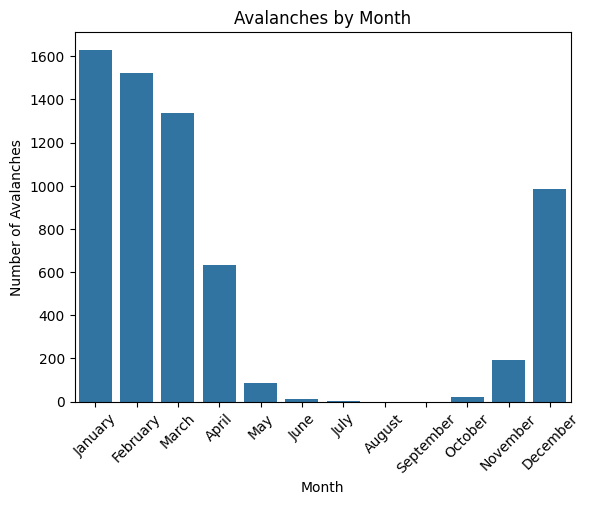

In [ ]:
plt.title('Avalanches by Month')
sb.barplot(data=avalanche_bymonth, x=avalanche_bymonth.keys(), y=avalanche_bymonth.values())
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Avalanches')
plt.show()

January is easily recognizable as the month with the most avalanches, with February and March close behind. I am surprised by the fact that the avalanches in March are greater than in December.

While I am not qualified to make any conclusions on *why*  the data is how it is, I would assume that December has a low amount of avalanches as the snow is freshly settled. In January, February, and March (after the snow has had time to shuffle and become unstable), the avalanches truly begin.

### Where do avalanches happen the most?

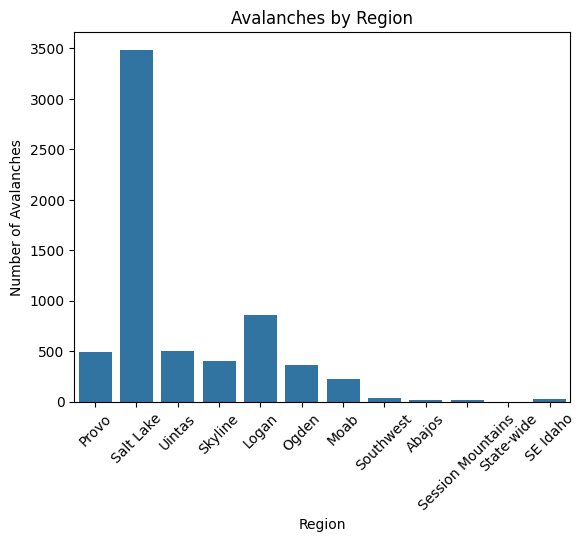

In [ ]:
plt.title('Avalanches by Region')
sb.countplot(data=avalanche_datadf, x='Region')
plt.xticks(rotation=45)
plt.xlabel('Region')
plt.ylabel('Number of Avalanches')
plt.show()

This is exactly what I expected. Salt Lake is the most populated region with many ski resorts and attention. It is also a very large area. Combining these factors leads to the assumption (and now evidence) that the Salt Lake region would have the most avalanches.

###Do region and avalanche trigger have a relationship?

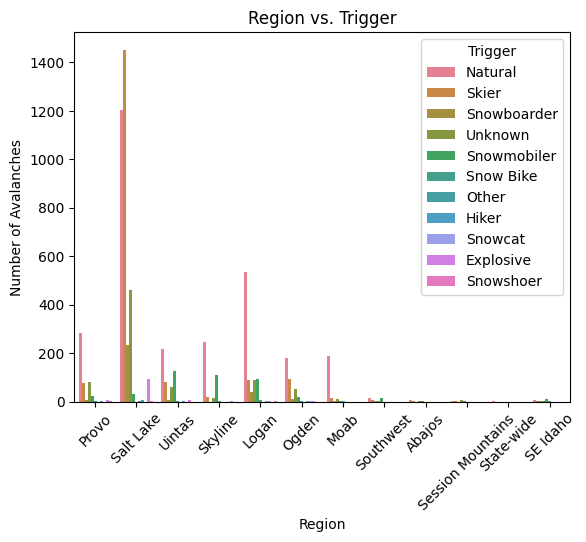

In [ ]:
plt.title('Region vs. Trigger')
q = sb.countplot(data=avalanche_datadf, x='Region', hue='Trigger')
plt.xticks(rotation=45)
plt.xlabel('Region')
plt.ylabel('Number of Avalanches')
plt.show()

I can observe that the Salt Lake region appears to have more Skier caused avalanches than any other region in comparison to their counts. Logan and Moab also appear to have more Natural caused avalanches than would be expected. Finally, the Uintas have a much higher amount of Snowmobiler caused accidents than would be expected.

# 8. Try an easy solution



### What test can I use to examine my data?

The first two of my questions can be answered with simple barplots. However, my third question on whether region and trigger are related needs a statistical test as evidence for any claims.

The most obvious statistical test (and one of my personal favorites for its flexibility) is a Chi-Squared Test of Independence. I used the same test in my second module assignment and it worked perfectly. I chose this test as it can determine if there is a dependency between two categorical variables (Region and Trigger), which is perfect for my question.

To be able to use a Chi-Squared Test of Independence, I first create a contingency table. I then use the Scipy Stats Chi-Squared test.

In [ ]:
# problem setup

# I found the 'isin' method on the Pandas website.
format_df = avalanche_datadf[avalanche_datadf['Region'].isin(['Salt Lake', 'Provo', 'Logan', 'Ogden', 'Uintas', 'Skyline'])]
# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
table_regionandtrigger = pd.crosstab(format_df['Region'], format_df['Trigger'])
regtrigstyled_table = table_regionandtrigger.style.set_caption('Avalanche Trigger by Region')
display(regtrigstyled_table)

# results
stat, p, dof, expected = chi2_contingency(table_regionandtrigger)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

Trigger,Explosive,Hiker,Natural,Other,Skier,Snow Bike,Snowboarder,Snowcat,Snowmobiler,Snowshoer,Unknown
Region,,,,,,,,,,,
Logan,0,2,534,0,91,6,42,1,92,2,91
Ogden,1,1,179,0,93,2,11,1,19,0,52
Provo,6,4,284,0,76,3,9,0,24,1,83
Salt Lake,93,8,1204,2,1452,0,233,0,31,3,461
Skyline,3,0,245,0,21,4,0,0,112,0,15
Uintas,8,1,217,0,80,3,9,0,127,0,60


Statistic: 1528.9849348602154
P Value: 2.5540237646495275e-287
Expected Frequencies
[[1.56622419e+01 2.25762045e+00 3.75752704e+02 2.82202557e-01
  2.55816618e+02 2.53982301e+00 4.28947886e+01 2.82202557e-01
  5.71460177e+01 8.46607670e-01 1.07519174e+02]
 [6.53048181e+00 9.41330711e-01 1.56672730e+02 1.17666339e-01
  1.06664536e+02 1.05899705e+00 1.78852835e+01 1.17666339e-01
  2.38274336e+01 3.52999017e-01 4.48308751e+01]
 [8.91347099e+00 1.28482465e+00 2.13843002e+02 1.60603081e-01
  1.45586693e+02 1.44542773e+00 2.44116683e+01 1.60603081e-01
  3.25221239e+01 4.81809243e-01 6.11897738e+01]
 [6.34311701e+01 9.14323173e+00 1.52177663e+03 1.14290397e+00
  1.03604245e+03 1.02861357e+01 1.73721403e+02 1.14290397e+00
  2.31438053e+02 3.42871190e+00 4.35446411e+02]
 [7.27630285e+00 1.04883645e+00 1.74565716e+02 1.31104556e-01
  1.18846280e+02 1.17994100e+00 1.99278925e+01 1.31104556e-01
  2.65486726e+01 3.93313668e-01 4.99508358e+01]
 [9.18633235e+00 1.32415601e+00 2.20389217e+02 1.6551950

### The Results
As always, the results are a little confusing. However, we can first notice that the P-Value is 2.554e-287. This is an absolutely minuscule P-Value, meaning that the results are statistically significant (the P-Value needs to be less than 0.05).

When we actually look at the results, it is shown that if there was no relation between region and trigger, the Salt Lake Region would have had approximately 1,000 Skier caused avalanches. However, the data contains nearly 1.5x that amount at 1,452! This shows that there exists a relation between Region and Trigger in the Sale Lake region with more Skier caused avalanches than should be expected.

Some other examples of noteworthy data are the number of Natural caused avalanches in Logan (much higher), the number of Snowmobiler caused avalanches in the Uintas (nearly 5 times as much), and the number of Natural caused avalanches in Salt Lake (300 less than expected).

## The Answers to my Questions

### When in the year to the most avalanches take place?
**Answer:** January and February

### Which regions are the most susceptible to avalanches?
**Answer:** The Salt Lake and Logan regions.

### Do region and avalanche trigger relate?
**Answer:** Yes. Some regions (like Salt Lake and Skiers) have higher counts than expected while others (like Salt Lake and Natural) have lower.

#Write Up


### My Question:
The question(s) that I chose to answer was the following: In the last ten years, when in the year do the most avalanches take place in Utah? What regions are most susceptible? Additionally, do region and avalanche trigger relate? Obviously, as there were three questions, I had a good amount of work to do.


My question is specific as it examines distinct features of the dataset (avalanche information table) that can be answered with work. For example, instead of asking "What kind of avalanches do different regions experience?", I asked "Do region and avalanche trigger relate?" While both questions have roughly the same meaning, my question is much more specific.


My question is aligned well with the dataset for obvious reasons. My questions were essentially formed by looking around at the dataset and questioning. As I did not come up with my question and look for a dataset, the dataset perfectly aligns with my question.


I believe that my question is interesting. While avalanche data might not be as exciting as the election or something along those lines, I found it very interesting to be able to locate the times and regions most susceptible to avalanche. I also found that cementing a connection between region and trigger was very satisfying. Overall, I believe that my question poses an interesting search into a somewhat niche dataset.


As I answered my questions, my questions were inherently questionable. Overall, I found that I enjoyed my questions more and more as the project went on. What started as a thought sprung from a niche dataset transformed into a question that I was invested in answering.


### Visualization
For my visualization, I decided to use countplots and a barplot. Both countplots and barplots excel at demonstrating categorical variables and their counts (which is exactly what my question dealt with). All three of my visualizations lead to conclusions that would have been weak without their help.


### Test
For this module assignment, I chose to use a Chi-Squared Test of Independence. As I partially explained in the EDA section, the Chi-Squared Test of Independence identifies a relation between two categorical variables. In my case, Region and Trigger were two categorical variables that I wanted to test for a connection. From this, the Chi-Squared Test of Independence was obvious.


The Chi-Squared Test of Independence is quickly becoming my favorite statistical test due to its reliability.


My test results prove a certain claim. The results "mean" that in certain regions (like Salt Lake), avalanches are triggered more often by certain factors (like a Skier) than what would be expected if there was no connection. I explore these results more in-depth in the EDA section, but the results prove that there is a connection between region and trigger.


### Data Cleaning
To clean this dataset, I needed to do a few things. First, I identified how many rows had missing values. When I noticed that the depth and width columns had by far the most missing values, I was glad when I realized that my question did not need either of them. For the couple hundred missing Trigger values, I simply replaced any empty cells with 'Unknown', a value that had already existed. Any other approach to this variable that did not include replacing it with 'Unknown' seemed risky. To clean the 33 missing 'Region' values, I thought about manually imputing the region by looking at the title. However, when confronted with the workload of doing that, the fact that I would only lose 0.5% of my data and that rows with empty regions were not relevant to my question, I opted to drop any rows with empty 'Region' values.


I also had to perform other small data cleaning operations, such as only using relevant columns, transforming the 'Date' value to a DateTime object, and resetting the index to not include the page number.

### Data Scraping
The data that I collected with data scraping was the table dataset on the Utah Avalanche Center website. The table was in a nearly tidy format, which made my work much simpler. I chose to scrape this data as it was both interesting and easy to access. When I examined the HTML for the page, I noticed that the tags for the data I wanted were clear and that I could iterate through the different pages by simply changing the ?page= number in the URL. Based on these facts, I chose to scrap the Utah Avalanche Center website.


I encountered many problems when scraping the data. The first problem was simply finding the tags that contained the data I was looking for. I had to improve my understanding of both HTML tags as a whole and the Beautiful Soup find_all method. Both of these problems persisted through much of the development process.


Another problem that I faced when scraping the data was content that was formatted strangely. Luckily, the majority of the page was very well documented and formatted. However, when I attempted to scrape the date, I noticed that it was in a very strange format with extra numbers and letters. The fix for this issue was very easy, but it was still a problem that I faced.


One limitation of my scraping approach is the bulky appearance and structure of nearly all my work. I attribute this to the fact that this is my first web scraping project. However, all of my code works and runs at a reasonably fast pace. Another limitation of my scraping method is the inability of my parser to be able to work with new information. Say a new variable was added to the page. Instead of simply being able to use the same method, I would have to add an entirely new section in the method to react to the new data. If I had potentially more knowledge about web scraping, I expect that I could have cleaned up my method.


### Ethics of Web Scraping in Module Assignment Three
I do not believe that the ethics of scraping the Utah Avalanche Center for a table that they provide are that questionable. The data is in the public domain and formatted in a way that is easy to scrape. I fully believe that the creator of the website expected it to be scraped eventually as much of the HTML was beautifully formatted and easy to understand. However, one potential ethical issue is the sudden increase in traffic. Say that the Utah Avalanche Center obtains funding from web visits to their website. Since all of my hundreds of visits to the websites were solely to scrape the data, they might have missed out on potential funding. Also, if my work was used to replace the Utah Avalanche Center, the website would not get the attention it deserves. However, I do not think that either of these issues is that important.


### Ethics of Web Scraping in Other Domains
One example of web scraping in another data-driven domain that I recently encountered was a website that presented its findings on the Texas Death Row inmate information. There are multiple potential ethical issues with this. For example, if the prisoners were not entirely comfortable with their last statements being shared (even though it is in the public domain), it would be ethical to produce their statements for thousands to see. Another potential ethical issue is the absorption of all potential traffic to the website that the Texas Criminal Department created and set up to contain their data. If one was to only read the website interpreting the results, they would both miss out on all the other features of the original website and decrease traffic to the original website.